In [1]:
import pandas as pd

In [2]:
df= pd.DataFrame()

df = pd.read_csv('texts_train.txt', sep="\t", encoding='UTF-8',header=0)
df['grade'] = pd.read_csv('scores_train.txt', sep="\t", encoding='UTF-8',header=0)
df.columns = ['comment', 'grade']
df.sample(5)

,comment,grade
7556,"Довольно своеобразное,и требующее определенных...",8
992,блестящая повесть!,10
6613,Такая книга не нуждается в рецензиях и коммент...,10
14892,"Отличный фильм, не просто тупой боевик. Фильм ...",10
9531,Отличный детектив!,9


In [3]:
import numpy as np
unique_grades = np.sort(df['grade'].unique())
print('all unique grades: ',unique_grades, type(unique_grades))

all unique grades:  [ 1  2  3  4  5  6  7  8  9 10] <class 'numpy.ndarray'>


In [9]:
df_new = pd.DataFrame()
comment = []
grade = []

for grades in unique_grades:
    counter = 0
    for i in range(len(df)):
        #for i in range(000/(len(unique_grades))):
        if (counter<300):
            if (grades == df['grade'][i]):
                comment.append(df['comment'][i])
                grade.append(df['grade'][i])
                counter = counter + 1
df_new['comment'] = comment
#Заменим значения оценок на 1,2,3
#Это облегчит подсчет ошибки
#1 - негативный отзыв
#2 - нейтральный
#3 - положительный
df_new['grade'] = grade
df_new['grade'] = df_new['grade'].replace(1, 0).replace(2, 0).replace(3, 0)
df_new['grade'] = df_new['grade'].replace(4, 1).replace(5, 1).replace(6, 1).replace(7, 1)
df_new['grade'] = df_new['grade'].replace(10, 2).replace(9, 2).replace(8, 2)
print('new unique grades: ',np.sort(df_new['grade'].unique()))
df_new.head

new unique grades:  [0 1 2]


<bound method NDFrame.head of                                                 comment  grade
0     Хотелось долго плеваться после того как я с тр...      0
1     ИМХО, в серии о Свароге Бушков исписался. Если...      0
2     Много был наслышан об этом авторе и вот взялся...      0
3     Да, тяжело читать безграмотную фэнтези. Хотя, ...      0
4     Попытка свести сюжет предыдущих книг в единое ...      0
...                                                 ...    ...
2995  книга не похожа ни на одну из тех,что вы читал...      2
2996  к Есенину у меня любовь не просто как к поэту,...      2
2997  очень чувственно, с болью, настоящей мужской б...      2
2998  назовите мне писателя, хотя бы близко напомина...      2
2999  несмотря на то,что поэзия Пастернака не произв...      2

[3000 rows x 2 columns]>

In [10]:
array_of_mean_thensors = []
grade = []
comment = []
uncomtiled_rows = 0
for i in range(len(df_new)):
    try:
        grade.append(df_new['grade'][i])
        comment.append(df_new['comment'][i])
    except:
        #in some cases, from my point of view, when comment is too large, the data has not processed, and it cause some 
        print('wtf')
        uncomtiled_rows = uncomtiled_rows + 1
        #print('Too long or to short comment')
print(uncomtiled_rows)
print(comment[0],' ',grade[0])

0
Хотелось долго плеваться после того как я с трудом осилил половину книги. На этом моё увлечения творчеством Никитина было закончено. Я даже не захотел читать уже купленную книгу ?Изгой? из любимого некогда цикла Трое из леса.   0


In [11]:
from string import punctuation
print(punctuation)
def preproccessing(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in punctuation])
    text = text.split(' ')
    #print ('Number of reviews :', len(text))
    return text
tokenized_corpus = [preproccessing(i) for i in comment ]
tokenized_corpus[0]

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


['хотелось',
 'долго',
 'плеваться',
 'после',
 'того',
 'как',
 'я',
 'с',
 'трудом',
 'осилил',
 'половину',
 'книги',
 'на',
 'этом',
 'моё',
 'увлечения',
 'творчеством',
 'никитина',
 'было',
 'закончено',
 'я',
 'даже',
 'не',
 'захотел',
 'читать',
 'уже',
 'купленную',
 'книгу',
 'изгой',
 'из',
 'любимого',
 'некогда',
 'цикла',
 'трое',
 'из',
 'леса']

In [12]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)} # word -> index
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)} # index -> word

vocabulary_size = len(vocabulary)
print(vocabulary)

['хотелось', 'долго', 'плеваться', 'после', 'того', 'как', 'я', 'с', 'трудом', 'осилил', 'половину', 'книги', 'на', 'этом', 'моё', 'увлечения', 'творчеством', 'никитина', 'было', 'закончено', 'даже', 'не', 'захотел', 'читать', 'уже', 'купленную', 'книгу', 'изгой', 'из', 'любимого', 'некогда', 'цикла', 'трое', 'леса', 'имхо', 'в', 'серии', 'о', 'свароге', 'бушков', 'исписался', 'если', 'первые', 'две', 'еще', 'интересно', 'то', 'остальное', 'общем', 'сварога', 'пора', 'убивать', 'много', 'был', 'наслышан', 'об', 'авторе', 'и', 'вот', 'взялся', 'прочесть', 'сказать', 'что', 'книга', 'разочаровала', '', 'ничего', 'смысловые', 'ляпы', 'каждом', 'шагу', 'например', 'команда', 'огонь', 'при', 'стрельбе', 'луков', 'мире', 'где', 'нет', 'индивидуального', 'огнестрельного', 'оружия', 'тд', 'громоздкий', 'вычурный', 'язык', 'отсутствие', 'концовки', 'путешествие', 'неизвестно', 'куда', 'зачем', 'слабая', 'мотивация', 'поступков', 'героев', 'гораздо', 'ниже', 'среднего', 'теперь', 'начинаю', 'пон

In [13]:
len(vocabulary), len(word2idx), len(idx2word)

(25465, 25465, 25465)

In [14]:
# Заменили слова в предложении на токены (str -> int)

comment_in_num = []
for sentence in tokenized_corpus:
    comment_in_num.append([word2idx[word] for word in sentence])
comment_in_num[6]
#tokenized_corpus[6]

[219,
 220,
 65,
 98,
 221,
 110,
 104,
 222,
 223,
 224,
 225,
 226,
 181,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 5,
 211,
 194,
 12,
 236,
 124,
 58,
 37,
 237,
 62,
 211,
 238,
 63,
 5,
 46,
 239,
 240,
 241,
 242,
 5,
 243,
 21,
 244,
 245,
 246,
 12,
 87,
 247,
 248,
 246,
 12,
 249,
 250,
 246,
 12,
 251,
 133,
 252,
 37,
 253]

In [15]:
len(comment_in_num) == len(tokenized_corpus) == len(grade)

True

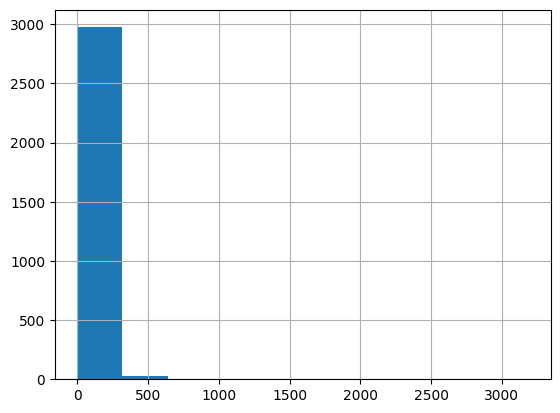

count    3000.000000
mean       36.308333
std        78.337574
min         1.000000
25%        11.000000
50%        21.000000
75%        38.000000
max      3187.000000
dtype: float64

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
comment_len = [len(x) for x in comment_in_num]
pd.Series(comment_len).hist()
plt.show()
pd.Series(comment_len).describe()

In [17]:
#  x, y -> матрица размерностью кол-во отзывов X желаемая длина предложений
def pad_features(reviews_int, seq_length):
    #Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    features = np.zeros((len(reviews_int), seq_length), dtype = int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]

        features[i,:] = np.array(new)

    return features

In [18]:
features = pad_features(comment_in_num, 200) # why 200???
features

array([[    0,     0,     0, ...,    32,    28,    33],
       [    0,     0,     0, ...,    49,    50,    51],
       [    0,     0,     0, ...,    21,   105,   106],
       ...,
       [    0,     0,     0, ...,  2368, 25460,   393],
       [    0,     0,     0, ...,   152, 22758,  1402],
       [    0,     0,     0, ...,    35,    13,    77]])

In [20]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
X_train, X_test, y_train, y_test = train_test_split(np.array(features),np.array(grade), test_size=0.20, random_state=42)
train_data = TensorDataset(torch.cuda.FloatTensor(X_train), torch.cuda.LongTensor(y_train))
test_data = TensorDataset(torch.cuda.FloatTensor(X_test), torch.cuda.LongTensor(y_test))
# dataloaders
batch_size = 30
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

Is CUDA supported by this system? True
CUDA version: 11.8


In [23]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([30, 200])
Sample input: 
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.1022e+04, 8.3130e+03,
         2.3900e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.9000e+01, 5.0000e+01,
         5.1000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.7000e+01, 1.7193e+04,
         1.7194e+04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.7000e+01, 4.9590e+03,
         2.2240e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0158e+04, 1.2700e+02,
         1.3300e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2700e+02, 2.1000e+01,
         6.8700e+02]], device='cuda:0')

Sample label size:  torch.Size([30])
Sample label: 
 tensor([2, 0, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 0, 0, 2, 1, 0, 0, 0, 0,
        1, 2, 2, 1, 1, 0], device='cuda:0')


In [24]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and SOFTMAX layers
        self.fc = nn.Linear(hidden_dim, output_size)
        #self.sig = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)



    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # softmax function
        softmax_out = self.softmax(out)

        softmax_out = softmax_out.view(batch_size, -1, self.output_size)
        softmax_out = softmax_out[:, -1]

        return softmax_out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

In [25]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocabulary)+1 # +1 for the 0 padding
output_size = 3
embedding_dim = 200
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(25466, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [42]:
import tqdm
# loss and optimization functions
lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# training params


counter = 0
print_every = 10
clip=5 # gradient clipping
# move model to GPU, if available
train_on_gpu = True
if(train_on_gpu):
    net.cuda()
    pass

net.train()
losses = []
epochs = 5
# train for some number of epochs
for e in tqdm.tqdm (range(epochs)):
    # initialize hidden state
    h = net.init_hidden(batch_size)
    loss_ = []
    # batch loop
    for inputs, labels in train_loader:
        net.train()
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.cuda.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        loss_.append(loss.item())
    losses.append(np.mean(loss_))

100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


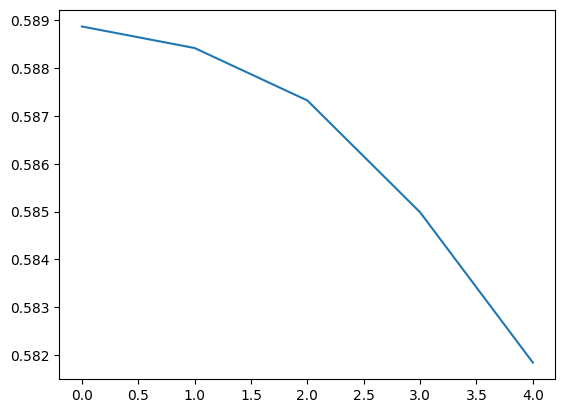

In [43]:
plt.plot(range(len(losses)), losses, label='train')

In [44]:
losses

[0.5888694182038308,
 0.5884188510477543,
 0.5873221099376679,
 0.5849841348826885,
 0.5818427853286267]

In [45]:
test_losses = [] # track loss
num_correct = 0
preds = []
test_labels = []

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.cuda.LongTensor)
    output, h = net(inputs, h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels)
    test_losses.append(test_loss.item())


    pred = torch.argmax(output.squeeze(), dim=1)

    # compare predictions to true label
    correct_tensor = pred.eq(labels.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    preds += list(pred.cpu().numpy())
    test_labels += list(labels.cpu().numpy())


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 1.078
Test accuracy: 0.458


In [46]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_labels, preds)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 79  81  38]
 [ 47 116  71]
 [ 29  59  80]]


In [47]:
from sklearn.metrics import accuracy_score

def weighted_accuracy(labels, preds):
    labels = np.array(labels)
    preds = np.array(preds)
    diff = np.abs(labels - preds)


    weights = 1 / (1 + diff)  # If the pred is closer to label -> weight is higher ,

    weighted_acc = accuracy_score(labels, preds, sample_weight=weights) # correct (weight(1) * (pred==labels)) / total weights

    return weighted_acc

weighted_acc = weighted_accuracy(test_labels, preds)

print(weighted_acc)

0.6450351837372947


In [48]:
def predict(net, test_review, sequence_length=200):

    net.eval()

    # tokenize review
    test_words = preproccessing(test_review)
    test_ints = []
    test_ints.append([word2idx[word] for word in test_words])
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    print(features)
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    batch_size = feature_tensor.size(0)

    # initialize hidden state
    h = net.init_hidden(batch_size)
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()

    # get the output from the model
    output, h = net(feature_tensor, h)

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.argmax(output.squeeze())
    # printing output value, before rounding
    # print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))

    # print custom response
    if(pred.item() == 1):
        print("Positive review detected!")
    elif (pred.item() == 2):
        print("Neutral review detected!")
    else:
        print("Negative review detected!")

In [49]:
predict(net, 'Ужасный фильм, мне не понравился, смотреть противно', 200)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0 2698 27

In [50]:
predict(net, 'очень хорошая книга', 200)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [51]:
predict(net, 'книга отстой можно в мусорку',200)

KeyError: 'мусорку'

In [52]:
predict(net, 'книга супер',200)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [53]:
predict(net, 'гавно фильм',200)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [54]:
predict(net, 'очень хороший фильм',200)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [59]:
predict(net, 'очень фильм хороший', 200)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   